In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import math
import os

In [3]:
%matplotlib inline
import ternary

In [4]:
def weights_to_points(weights):
    return weights / np.sum(weights, axis=2)[:,:, np.newaxis]

In [5]:
def sigmoid(x,centre,sharpness):
    return np.exp(sharpness*(x-centre))/(1+np.exp(sharpness*(x-centre)))

In [6]:
def color_point(x, y, z, scale):
    w = 255
    x_color = x * w / float(scale)
    y_color = y * w / float(scale)
    z_color = z * w / float(scale)
    r = math.fabs(w - y_color) / w
    g = math.fabs(w - x_color) / w
    b = math.fabs(w - z_color) / w
    return (r, g, b, 1.)

In [7]:
def colour_points(points,alpha):
    # assumes points sum to 1 row-wise
    colours = []
    for i in points:
        colours.append((i[0],i[1],i[2],alpha))
    return colours

In [8]:
def corner_colours(x,y,z,centre,sharpness):
    x_color = sigmoid(x,centre,sharpness)
    y_color = sigmoid(y,centre,sharpness)
    z_color = sigmoid(z,centre,sharpness)
    return (x_color, y_color, z_color, 1.)

In [9]:
def generate_heatmap_data(scale, resolution=2):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale*resolution):
        d[(i/resolution, j/resolution, k/resolution)] = color_point(i/resolution, j/resolution, k/resolution, scale)
    return d

In [10]:
# Make images higher resolution and set default size
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (4, 4)
matplotlib.rcParams['figure.facecolor'] = '1.0'
import matplotlib.pyplot as plt

In [11]:
def color_point(x, y, z, scale):
    w = 255
    x_color = x * w / float(scale)
    y_color = y * w / float(scale)
    z_color = z * w / float(scale)
    r = math.fabs(w - y_color) / w
    g = math.fabs(w - x_color) / w
    b = math.fabs(w - z_color) / w
    return (r, g, b, 1.)

In [17]:
import os
os.path.basename('./fz_weights/jk_input_weighted_128x3_PROTEINS_800_2e-04.npy')[:-4]

'jk_input_weighted_128x3_PROTEINS_800_2e-04'

In [93]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (4, 4)
matplotlib.rcParams['figure.facecolor'] = '1.0'
import matplotlib.pyplot as plt

import os

def plot_run(load_file, save_folder, aggregators=1, features=0, separate_folds=False, per_feature=False):
    """
    Produce ternary plots from weights data.
    - expects weights as ndarrays saved as .npy with dimensions [fold, epoch, weight]
    - expects aggregators*3 many weights (3 per aggregator) unless per_feature is True when instead expects
      aggregators*features*3 (currently assumes fixed features per layer but may update this)
    together these allow us to parse the weights per (gr)aggregator
    """
    weights = np.load(load_file)
    folds = weights.shape[0]
    
    # if it's not per feature then we can recover the number of aggregators
    # from the last dimension of the weights (/3)
    if per_feature == False:
        aggregators = int(weights.shape[-1]/3)
    
    # get the name of the run from the load_file (dropping .npy)
    run_identifier = os.path.basename(load_file)[:-4]
    
    if separate_folds:
        for agg in range(aggregators):
            # slice by aggregator then convert to ternary points
            points_agg = weights_to_points(weights[...,agg:agg+3])
            for fold in range(folds):
                # ------ plotting part 
                # take the points
                points = points_agg[fold]
                ## Sample trajectory plot
                figure, tax = ternary.figure(scale=1)
                figure.set_size_inches(5, 5)

                tax.boundary()
                tax.gridlines(multiple=1./2, color="black")
                
                title_string = run_identifier + ' – layer ' + str(agg) + ', fold ' + str(fold)
                
                tax.right_corner_label("Max", fontsize=8)
                tax.top_corner_label("Sum", fontsize=8,  offset=0.16)
                tax.left_corner_label("Mean", fontsize=8)
                
                tax.set_title(title_string, fontsize=8, pad=20)

                tax.new_colored_trajectory(points, linewidth=1.0, label="Curve")
                tax.arrow(points, arrows=0, start=False, end=True, lw=1., head_width=0.005)
                tax.ticks(axis='lbr', multiple=1./2, linewidth=1, tick_formats="%.1f", offset=0.03)

                tax.get_axes().axis('off')
                tax.clear_matplotlib_ticks()
                # ------ end of plotting part
                
                # save
                save_string = run_identifier + '_plot_' + str(agg) + '_' + str(fold) +'.png'
                tax.savefig(save_folder+save_string)
    else:
        for agg in range(aggregators):
            # slice by aggregator then convert to ternary points
            points_agg = weights_to_points(weights[...,agg:agg+3])

            # ------ plotting part 
            ## Sample trajectory plot
            figure, tax = ternary.figure(scale=1)
            figure.set_size_inches(5, 5)

            tax.boundary()
            tax.gridlines(multiple=1./2, color="black")
                
            title_string = run_identifier + ' – layer ' + str(agg)
            
            tax.right_corner_label("Max", fontsize=8)
            tax.top_corner_label("Sum", fontsize=8,  offset=0.16)
            tax.left_corner_label("Mean", fontsize=8)

            tax.set_title(title_string, fontsize=8, pad=20)

            for fold in range(folds):
                points = points_agg[fold]
                tax.new_colored_trajectory(points, linewidth=1.0, label="Curve")
                tax.arrow(points, arrows=0, start=False, end=True, lw=1., head_width=0.005)
                
            #tax.ticks(axis='lbr', multiple=1./2, linewidth=1, tick_formats="%.1f", offset=0.03)

            tax.get_axes().axis('off')
            tax.clear_matplotlib_ticks()
            # ------ end of plotting part

            # save
            save_string = run_identifier + '_plot_' + str(agg) + '_' + 'stacked_folds.png'
            tax.savefig(save_folder+save_string)

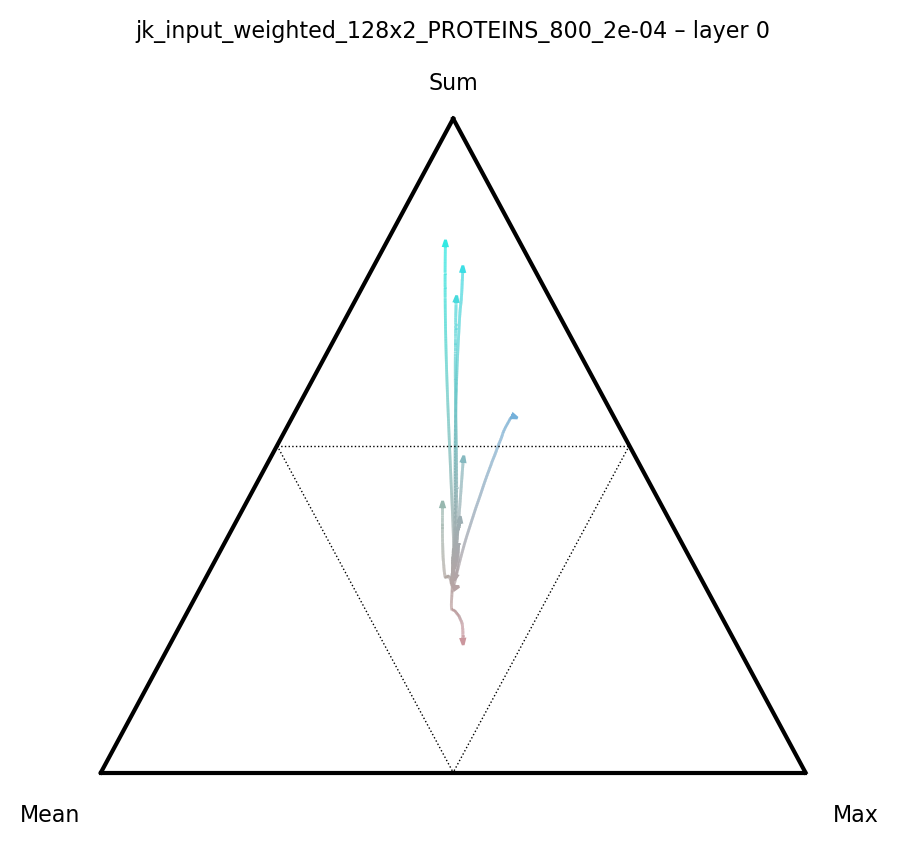

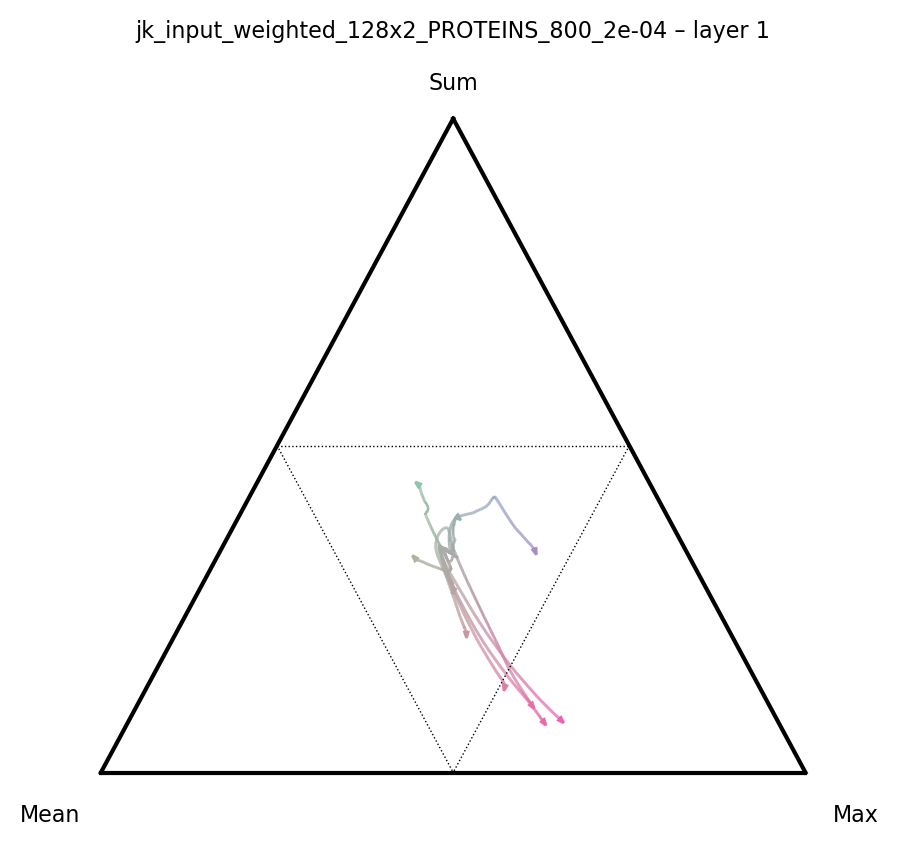

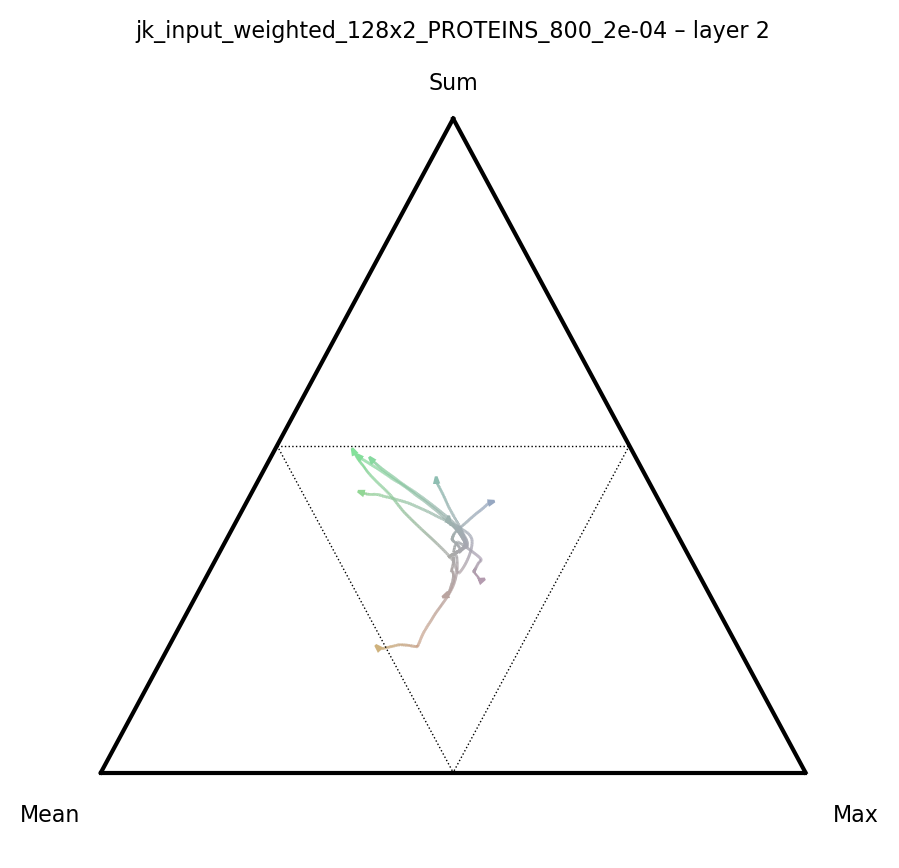

In [96]:
plot_run('./fz_weights/jk_input_weighted_128x2_PROTEINS_800_2e-04.npy', './')

In [22]:
weights = np.load('./fz_weights/jk_input_weighted_128x3_PROTEINS_800_2e-04.npy')
weights = weights[...,0:3]
weights.shape

(10, 800, 3)

In [100]:
points = weights_to_points(weights)[3]

In [55]:
a = 0.05
t = np.arange(-20,15,0.05)
x = np.exp(np.cos(t) / np.sqrt(1+a*a*t*t))*0.01
y = np.exp(np.sin(t) / np.sqrt(1+a*a*t*t))*0.01
z = np.exp(- a*t / np.sqrt(1+a*a*t*t))
m = x + y + z
points = np.stack((x/m, y/m, z/m), axis = 1)

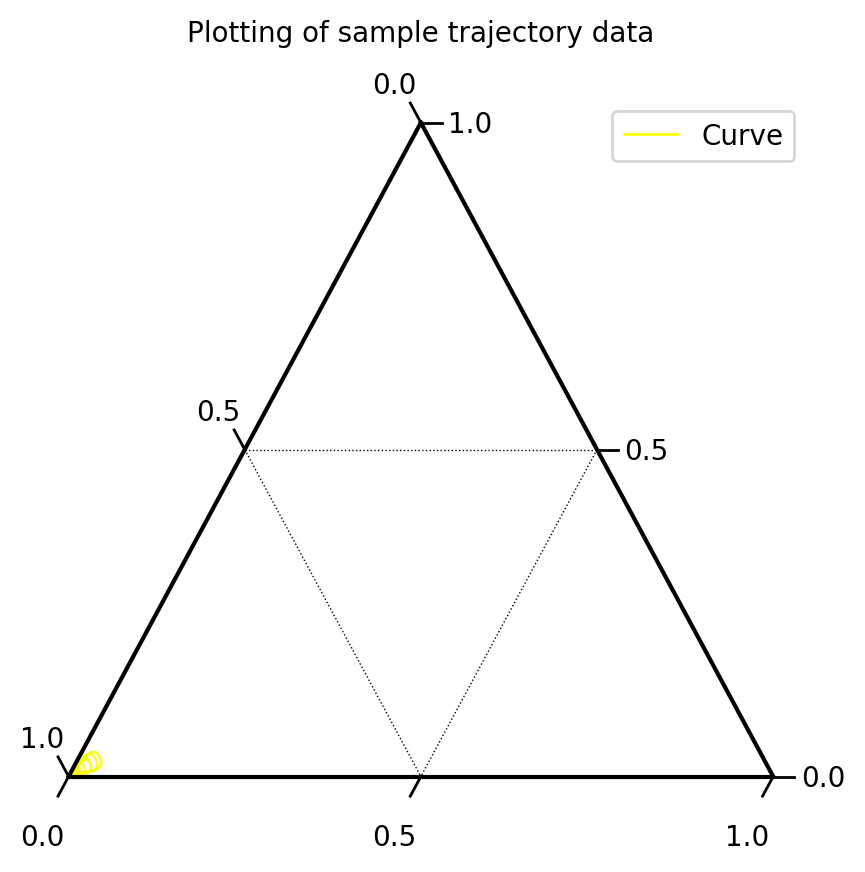

In [56]:
## Sample trajectory plot
figure, tax = ternary.figure(scale=1)
figure.set_size_inches(5, 5)

tax.boundary()
tax.gridlines(multiple=1./2, color="black")
tax.set_title("Plotting of sample trajectory data", fontsize=10, pad=20)

#tax.plot_colored_trajectory(points, cmap="hsv", linewidth=1.0, label="Mix")
tax.new_colored_trajectory(points, linewidth=1.0, label="Curve")
tax.arrow(points, arrows=1, start=True, end=True, lw=1., head_width=0.005)
tax.ticks(axis='lbr', multiple=1./2, linewidth=1, tick_formats="%.1f", offset=0.03)

tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.legend()
tax.savefig('./plot.png')
tax.show()

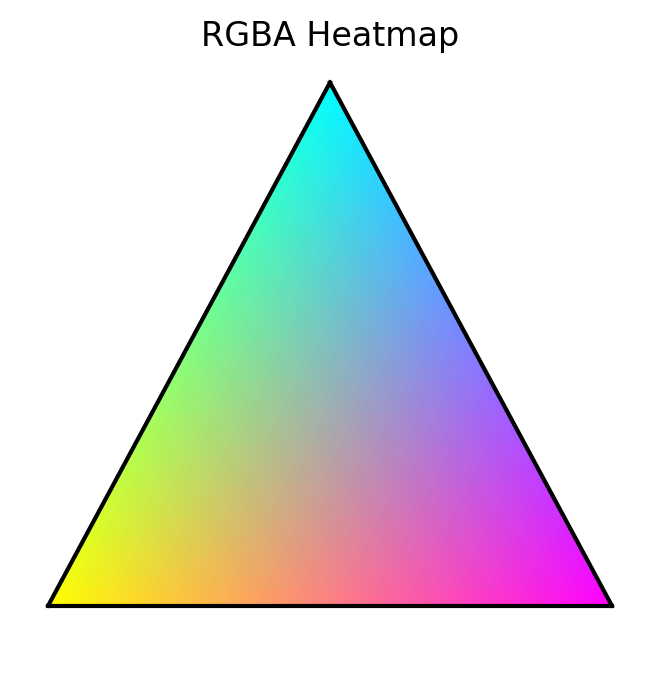

In [39]:
def color_point(x, y, z, scale):
    w = 255
    x_color = x * w / float(scale)
    y_color = y * w / float(scale)
    z_color = z * w / float(scale)
    r = math.fabs(w - y_color) / w
    g = math.fabs(w - x_color) / w
    b = math.fabs(w - z_color) / w
    return (r, g, b, 1.)


def generate_heatmap_data(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = color_point(i, j, k, scale)
    return d

scale = 80
data = generate_heatmap_data(scale)
figure, tax = ternary.figure(scale=scale)
tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False)
# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.boundary()
tax.set_title("RGBA Heatmap")
plt.show()